In [1]:
from IPython.display import Image

Translated by [Naoto Usuyama](https://github.com/usuyama) December 22, 2017

# CNTK 102:  Feed Forward Networkでシミュレーションデータの学習

このチュートリアルでは、CNTK python library のコンポーネントをすばやく組み合わせ、**分類(classification)**タスクを行います。機械学習にすでに馴染みがあるか、Logistic Regressionのチュートリアルをお読み頂いた方は、*導入*セクションを飛ばして進めてください。

## 導入

**NOTE**: CNTK 101チュートリアルと同じ問題設定です。

**問題設定 (分類問題)**:
ある患者の腫瘍が良性か悪性かを判別して欲しいと、ある病院から依頼を受けました。与えられるデータは患者の年齢と腫瘍の大きさです。実際の現場では、より多くの特徴量を扱いデータが取得された病院や研究所も考慮しなければいけませんが、今回は簡単のためシミュレーションデータを使います。直感的には、若い患者で腫瘍のサイズが小さいほど、良性の可能性が高いような気がします。今回使うシミュレーションデータをプロットすると、下のような図になります(青が良性、赤が悪性) 。

In [2]:
# Figure 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

**ゴール**:
２つの特徴量(年齢、腫瘍の大きさ)から、患者の腫瘍が良性か悪性かを推定します。

CNTK 101 チュートリアルでは、線形分類器である Logistic Regression を用いましたが、いくつか誤った分類をしてしまいました。多くの現実問題では良い特徴量を事前に得ることは難しく、線形分類器では良い精度を出せません。このチュートリアルでは CNTK 101 チュートリアルで作成した線形ユニットを組み合わせて非線形分類器を作ります。後半のチュートリアルでは、非線形分類器を用いてデータから自動的に良い特徴量を抽出する方法を学びます。

**アプローチ**: 
一般的に、モデルの学習は5つのステップで行われます。(1) 読み込み (Data reading)、 (2) 前処理 (Data reprocessing)、(3) モデルの作成 (Creating a model)、 (4) モデルの学習 (Learning the model prameters)、(5) モデルの評価のうち、(3) にfeed forward networkを使う以外は、CNTK 101 チュートリアルと全て同じです。

## Feed forward network model (順伝播型ネットワークモデル)

今回のモデルは、複数のLogistic Regression分類器を組み合わせて、より複雑なクラスの境界(decision boundary)を表現できます。

In [3]:
# Figure 2
Image(url="https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif", width=200, height=200)

Feedforward neural network はユニット同士のネットワークが**サイクルにならない(ループを作らない)**ネットワークです。このネットワークでは、情報はインプットノードから隠れノードを通り、アウトプットノードへと一方向に流れます。

In [4]:
# Import the relevant components
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

## シミュレーションデータの生成

CNTK 101 チュートリアルをご覧になった場合は、<a href='#Model Creation'>Model Creation</a>までスキップしてください。

`numpy` ライブラリを使って腫瘍データを模したデータを生成します。それぞれのデータポイントは、2つの特徴量 (年齢と腫瘍の大きさ)を持ち、良性か悪性のどちらかのクラスに属します。

今回は、2つのクラス(ラベル)は0か1で表されるので、バイナリ(二値)分類問題と言えます。

In [5]:
# Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim = 2
num_output_classes = 2

### 入力とラベル

このチュートリアルではシミュレーションデータを使いますが、実際の問題では[reader][]を使ってデータを読み込みます。[reader][]の使い方については、後ほど扱います。シミュレーションで生成した年齢の値は、もう一つの変数(腫瘍の大きさ)と同じ範囲の値になるようにスケールダウンします。このスケールを調整する作業は重要な前処理なので、チュートリアルの後半でより詳しく扱う予定です。実際の問題でより多くの特徴量が利用可能な場合は、CNTKでは[tensor][]として多次元データを表します。[tensor][]についても後ほど扱う予定です。

[reader]: https://github.com/Microsoft/CNTK/search?p=1&q=reader&type=Wikis&utf8=%E2%9C%93
[tensor]: https://en.wikipedia.org/wiki/Tensor

In [6]:
# Helper function to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    X = X.astype(np.float32)    
    # converting class 0 into the vector "1 0 0", 
    # class 1 into vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y   

In [7]:
# Create the input variables denoting the features and the label data. Note: the input 
# does not need additional info on number of observations (Samples) since CNTK first create only 
# the network tooplogy first 
mysamplesize = 64
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)


入力データを可視化してみましょう。

**Note**: もしimport `matplotlib.pyplot` が失敗した場合、`conda install matplotlib` か `pip install` を使って、`pyplot` バージョン依存を解決してください。

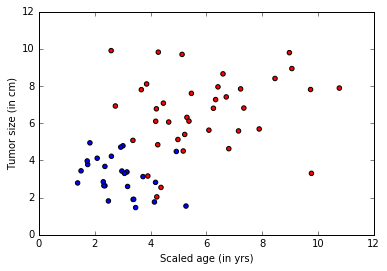

In [8]:
# Plot the data 
import matplotlib.pyplot as plt
%matplotlib inline

# given this is a 2 class 
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

<a id='#Model Creation'></a>
## モデルの作成

今回のネットワークは、隠れノード数50(`hidden_layers_dim`)の隠れレイヤー(`num_hidden_layers`)が2層です。

In [9]:
# Figure 3
Image(url="http://cntk.ai/jup/feedforward_network.jpg", width=200, height=200)

上図は簡略化してありますが、緑の2層の隠れレイヤーは、それぞれ50個(`hidden_layers_dim`)の隠れノードを持ちます。また、上図では省略されていますが、各隠れレイヤーはバイアスノードを持ちます。

In [10]:
num_hidden_layers = 2
hidden_layers_dim = 50

CNTKにおける、ネットワークの入力:
-- **input** 変数
> CNTKでは、input_variable 関数を使って、入力コンテナを作ります。今回は、特徴量は2つなので、次元数2の入力コンテナを作ります。

In [11]:
# The input variable (representing 1 observation, in our example of age and size) x, which 
# in this case has a dimension of 2. 
#
# The label variable has a dimensionality equal to the number of output classes in our case 2. 

input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

## Feed forward Network のセットアップ

それでは、Feedforward Network を構成していきます。最初のレイヤーは、入力となる$m$次元(`input_dim`)の特徴量ベクター($\bf{x}$)を受け取り、*evidence*を出力します。*evidence* ($\bf{z_1}$) は、$n$ (`hidden_layer_dim`) 次元のベクターです。それぞれの特徴量に、行列 $\bf{W}$ (サイズ $m \times n$)で表される重みを掛けて、*evidence* は計算できます。Note: **太字**は行列/ベクターを表します。

$$\bf{z_1} = \bf{W} \cdot \bf{x} + \bf{b}$$ 

ただし、$\bf{b}$は$n$のバイアスベクターです。

`linear_layer`関数では、上の数式で表されている通り、
0. CNTKのtimesオペレーションを使って、重み行列($\bf{W}$を特徴量ベクター($\bf{x}$)に掛け、
1. 最後に、バイアスベクターを足します。

重み行列とバイアスベクターは、CNTKの[parameter][]として定義されています。

[parameter]: https://www.cntk.ai/pythondocs/cntk.ops.html?highlight=parameter#cntk.ops.parameter

In [12]:
def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]
    
    weight = C.parameter(shape=(input_dim, output_dim))
    bias = C.parameter(shape=(output_dim))

    return bias + C.times(input_var, weight)

次に、*evidence* (`linear_layer`の出力)を、*activation functions* という非線形な関数で変換します。様々な[activation functions][]があり、**Sigmoid**や**Tanh**が歴史的に人気ですが、今回は**Sigmoid**関数を使います。

**質問**: ぜひ、他の[activation functions][]を、`nonlinearity`引数に渡して、試してみてください。

[activation functions]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

In [13]:
def dense_layer(input_var, output_dim, nonlinearity):
    l = linear_layer(input_var, output_dim)
    
    return nonlinearity(l)

これで、隠れレイヤーが1つできたので、1つ目のレイヤーの出力 ($\bf{h_1}$) を２つ目の隠れレイヤーの入力にして、レイヤー同士を繋げます。

今回は2層だけなので、このように書けます。

    h1 = fully_connected_layer(input, hidden_layer_dim, sigmoid)
    h2 = fully_connected_layer(h1, hidden_layer_dim, sigmoid)

後半のチュートリアルのように、より多くのレイヤーが必要な場合(convolutional networkやrecurrent network)でも、

    h = dense_layer(input_var, hidden_layer_dim, sigmoid)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, sigmoid)

このように簡潔に表現できます。

In [14]:
# Define a multilayer feedforward classification model
def fully_connected_classifier_net(input_var, num_output_classes, hidden_layer_dim, 
                                   num_hidden_layers, nonlinearity):
    
    h = dense_layer(input_var, hidden_layer_dim, nonlinearity)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, nonlinearity)
    
    return linear_layer(h, num_output_classes)

`z` はネットワーク全体のアウトプットになります。

In [15]:
# Create the fully connected classfier
z = fully_connected_classifier_net(input, num_output_classes, hidden_layers_dim, 
                                   num_hidden_layers, C.sigmoid)

CNTK primitives を使ってネットワークを記述する方法を紹介しましたが、 [layers library](https://www.cntk.ai/pythondocs/layerref.html) を使った方が実際には便利です。 It provides predefined commonly used “layers” (lego like blocks), which simplifies the design of networks that consist of standard layers layered on top of each other. For instance, ``dense_layer`` is already easily accessible through the [Dense](https://www.cntk.ai/pythondocs/layerref.html#dense) layer function to compose our deep model. We can pass the input variable (`input`) to this model to get the network output. 

**Suggested task**: Please go through the model defined above and the output of the `create_model` function and convince yourself that the implementation below encapsulates the code above.


In [16]:
def create_model(features):
    with C.layers.default_options(init=C.layers.glorot_uniform(), activation=C.sigmoid):
        h = features
        for _ in range(num_hidden_layers):
            h = C.layers.Dense(hidden_layers_dim)(h)
        last_layer = C.layers.Dense(num_output_classes, activation = None)
        
        return last_layer(h)
        
z = create_model(input)

### モデルパラメータの学習

ネットワークのセットアップできたので、それぞれのレイヤーが持つパラメータ $\bf w$ と $\bf b$ を学習していきます。そのため、`softmax`関数で最終的な`evidence`($\bf z_{final~layer}$)を、確率分布\textbf{p}に変換します。

$$ \textbf{p} = \mathrm{softmax}(\bf{z_{final~layer}})$$ 

[softmax function][]の処理は、計算されたevidenceをクラス分類の確率分布に変換するような、activation関数としても考えられます。他のactivation関数は[こちら][]を参照ください。

[softmax function]: https://www.cntk.ai/pythondocs/cntk.ops.html?highlight=softmax#cntk.ops.softmax

[こちら]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## 学習

CNTK 101 チュートリアルをご覧になった場合は、<a href='#Run the trainer'>Run the trainer</a>まで飛ばしてください。

上で述べたように、`softmax`関数の出力は観測値がそれぞれのクラスに属する確率になります。推定された確率分布が正解の分布にどれくらい近いかを表す関数を*cost*関数または*loss*関数といいます。*cost*関数または*loss*関数の値が小さくなるように、つまり、出力された確率が正解のクラスになるべく近くなるようにモデルの学習を行っていきます。

*cost/loss* 関数として、[`Cross-entropy`][]はよく使われており、確率分布同士の近さを非負の値で返します。

$$ H(p) = - \sum_{j=1}^C y_j \log (p_j) $$

$p$ は`softmax`関数による推定確率分布、$y$は正解ラベル(ground-truth)です。2クラス問題の場合、`label`変数は2次元(`num_output_classes`と$C$に等しい)です。$y$、$p$共に、該当するクラスの要素が1、それ以外($C-1$次元)の要素は0の、$C$次元ベクターでは表されます。後ほど時間を取ってCross-Entropyを[よく理解する][]ことをおすすめします。

[`cross-entropy`]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[よく理解する]: http://colah.github.io/posts/2015-09-Visual-Information/

In [17]:
loss = C.cross_entropy_with_softmax(z, label)

#### 評価

`loss`関数を基準に学習したモデルを、[`classificaiton_error`][]関数を使って評価します。モデルの出力結果と正解(ground-truth)がいくつ一致したかを返します。

[`classificaiton_error`]: https://www.cntk.ai/pythondocs/cntk.ops.html#cntk.ops.classification_error

In [18]:
eval_error = C.classification_error(z, label)

### 学習の調整

`loss`関数を小さくするために様々な最適化手法([optimization][])がありますが、今回は[Stochastic Gradient Descent][] (`sgd`)を使います。通常`sgd`では、ランダムな値でパラメータを初期化し、最急降下法([gradient-decent][])で反復的にパラメータを最適化していきます。それぞれのイテレーション(反復)では、データの一部を取り出して(*minibatch*と呼ぶ)、パラメータの更新に使います。大規模なデータセットに対してもメモリにのる分だけ*minibatch*として取り出し、効率的に学習を進められます。`loss`関数の値があまり変わらなくなるか、指定回数以上反復したら、学習を終了します。

最適化の際の重要なパラメータとして`learning_rate`があります。今のところ"一度のイテレーションでどの程度パラメータを変化させるか"を調節するパラメータと考えておけば大丈夫ですが、より詳しくはチュートリアルの後半で扱う予定です。

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Stochastic Gradient Descent]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[gradient-decent]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [19]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = C.learning_parameter_schedule(learning_rate) 
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

学習の様子を可視化するためのヘルパー関数を用意しておきます。

In [20]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=10):    
    if len(a) < w: 
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):    
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {}, Train Loss: {}, Train Error: {}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

<a id='#Run the trainer'></a>
### 学習

今回は、一回のイテレーションで使うサンプル数(`minibatch_size`)を25、学習する総サンプル数(`num_samples_to_train`)を20000と設定します。シミュレーションデータなので幾らでもサンプルを生成できますが、実際の問題では答え(ground-truth)がわかっているデータのうち、例えば70%で学習をし、残り30%で学習したモデルの評価をする事があります。

これでFeed Forawrdネットワークを学習する準備ができました。

In [21]:
#Initialize the parameters for the trainer
minibatch_size = 25
num_samples = 20000
num_minibatches_to_train = num_samples / minibatch_size

In [22]:
#Run the trainer on and perform model training
training_progress_output_freq = 20

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Specify the input variables mapping in the model to actual minibatch data for training
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=0)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)


次々にminibatchをモデルに渡し、トレーニングしていく過程のエラーの様子をプロットしてみます。徐々にトレーニングロスは減っていきますが、所々でバンプしている箇所があります。これは、学習の途中に見慣れないデータがminibatchに含まれると起こります。

バンプを減らす一つの方法は、minibatchのサイズを大きくすることです。今回のチュートリアルのような小さなデータでは、データセット全体を毎回の反復に使うことも可能ですが、実際の大規模なデータには何度も勾配の計算を繰り返すのは現実的ではありません。

今回は`sgd` (stochastic gradient descent) を使っていますが、CNTKで利用可能なより高度な最適化手法を、後半のチュートリアルで紹介する予定です。

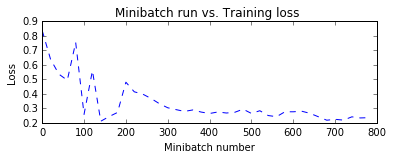

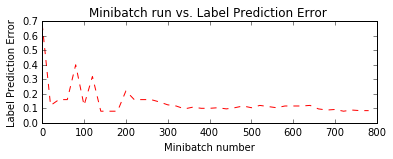

In [23]:
#Compute the moving average loss to smooth out the noise in SGD    

plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

#Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss ')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error ')
plt.show()

## 評価 / テスト

これでネットワークの学習ができました。学習に使っていないデータを分類してみて、ネットワークの性能を評価してみましょう(**testing**と言う)。シミュレーションデータをさらに生成し、`trainer.test_minibatch`関数で予測を行います。

In [24]:
#Generate new data
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({input : features, label : labels})  

0.12

テスト結果 (汎化誤差、"out of sample" エラーとも呼ぶ) は、ほぼトレーニングエラーと同じになりました。これは、新しいデータ (学習に使っていないデータ) に対してもうまくモデルが働いていると考えられます。

ここまでは集計したエラーを確認してきましたが、ここでそれぞれのデータポイントの様子を確認してみます。ネットワークの出力を`softmax`関数を通し、`eval`関数を使うと推定された確率が得られます。確率は2次元ベクター(2クラス問題なので)で表されます。

#### なぜ、`softmax`関数をネットワークの出力に通す必要があるのでしょうか？

In [25]:
# Figure 4
Image(url="http://cntk.ai/jup/feedforward_network.jpg", width=200, height=200)

In [26]:
out = C.softmax(z)

まだ見ていないデータを分類してみましょう。

In [27]:
predicted_label_probs = out.eval({input : features})

In [28]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(row) for row in predicted_label_probs])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


**実験のヒント**
- シミュレーションデータの分布を変えると、分類機はどう動作するでしょうか？
- パラメータを変えてみるとどうなるでしょうか？例えば、minibatch_sizeを25から64にしてみてください。エラーレートはどうなるでしょうか？Logistic regression (前回のチュートリアル) と比べると、エラーレートはどうでしょうか?
- 違う最適化手法 (例えば、Adam (`fsadagrad`))を試してみてください。
    learner = fsadagrad(z.parameters(), 0.02, 0, targetAdagradAvDenom=1)
- ネットワークを変更して、トレーニングエラーを減らすますか？どのタイミングで*overfitting*が起きるか確認してみてください。

#### コード
- [FeedForwardNet.py][]

[FeedForwardNet.py]: https://github.com/Microsoft/CNTK/blob/v2.0.beta2.0/bindings/python/examples/NumpyInterop/FeedForwardNet.py